# EDA

http://www.astro.cornell.edu/research/projects/compression/entropy.html
Image entropy is a quantity which is used to describe the `business' of an image, i.e. the amount of information which must be coded for by a compression algorithm. Low entropy images, such as those containing a lot of black sky, have very little contrast and large runs of pixels with the same or similar DN values. An image that is perfectly flat will have an entropy of zero. Consequently, they can be compressed to a relatively small size. On the other hand, high entropy images such as an image of heavily cratered areas on the moon have a great deal of contrast from one pixel to the next and consequently cannot be compressed as much as low entropy images.

Lets start with a gray-scale image. One intuitive approach is to consider the image as a bag of pixels and compute
H=−∑kpklog2(pk)
where K is the number of gray levels and p is the probability associated with gray level k.

Entropy is just a way of expressing the number of states of a system. A system with many states has a high entropy, and a system with few states has a low entropy.

## Imports

In [195]:
from glob import glob
import json
import numpy as np
import pandas as pd
import PIL
from scipy.stats import entropy

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set_style("dark", {'axes.grid' : False})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load merged data

In [4]:
app_ui_df = pd.read_pickle('clean_data/app_ui_df.pkl')
app_ui_df.shape

(9567, 17)

In [5]:
app_ui_df.head(2)

,app_package_name,app_name,app_category,star_rating,average_rating,number_of_ratings,min_ratings,ui_number,interaction_trace_number,ui_number_in_trace,filename,app_name_num,app_cat_num,star_rating_num,average_rating_num,number_of_ratings_num,filename_num
0,B4A.BigFivePersonalityTest,[Big 5 Personality Test],Education,[3.6],[6698],"[ 1,000,000 - 5,000,000 ]",[1000000],[49783],[0],[221],[app_uis/49783.jpg],1,1,1,1,1,1
1,CN.MyPrivateMessages,[Calculator],Communication,[4.3],"[17020, 16918, 16919]","[ 1,000,000 - 5,000,000 ]",[1000000],[26083],[0],[15],[app_uis/26083.jpg],1,1,1,3,1,1


#### Subset to only columns of interest

In [6]:
app_ui_df['app_names'] = app_ui_df.app_name.map(lambda x: ', '.join(x))
app_ui_df['star_rating_ave'] = app_ui_df.star_rating.map(lambda x: np.mean(x))
app_ui_df['average_rating_ave'] = app_ui_df.average_rating.map(lambda x: np.mean(x))
app_ui_df['min_ratings_ave'] = app_ui_df.min_ratings.map(lambda x: np.mean(x))

In [7]:
cols_keep = ['app_package_name', 'app_names', 'app_category', 'star_rating_ave', \
             'average_rating_ave', 'min_ratings_ave', 'filename', 'filename_num']

app_ui_df_clean = app_ui_df[cols_keep]

In [8]:
app_ui_df_clean.head(2)

,app_package_name,app_names,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename,filename_num
0,B4A.BigFivePersonalityTest,Big 5 Personality Test,Education,3.6,6698.000000,1000000.0,[app_uis/49783.jpg],1
1,CN.MyPrivateMessages,Calculator,Communication,4.3,16952.333333,1000000.0,[app_uis/26083.jpg],1


#### Explode filename list into single rows for easy manipulation later

In [9]:
filename_exp = app_ui_df_clean.filename.apply(pd.Series).stack().reset_index(
    level=1, drop=True).to_frame('filename_exp')

In [10]:
filename_exp.shape

(70959, 1)

In [11]:
app_ui_exp = pd.concat([app_ui_df_clean, filename_exp], axis=1)
app_ui_exp.reset_index(drop=True, inplace=True)
app_ui_exp.rename(columns={'filename': 'filename_list'}, inplace=True)
app_ui_exp.shape

(70959, 9)

In [12]:
app_ui_exp.groupby('app_package_name')['app_package_name'].count().shape

(9567,)

In [14]:
app_ui_exp[['app_package_name', 'filename_num']].head(10)

,app_package_name,filename_num
0,B4A.BigFivePersonalityTest,1
1,CN.MyPrivateMessages,1
2,DOCECG2.doctor,1
3,Gecko.Droid.PhysicsHelper,5
4,Gecko.Droid.PhysicsHelper,5
5,Gecko.Droid.PhysicsHelper,5
6,Gecko.Droid.PhysicsHelper,5
7,Gecko.Droid.PhysicsHelper,5
8,HinKhoj.Dictionary,20
9,HinKhoj.Dictionary,20


In [12]:
app_ui_exp.groupby('app_package_name')['app_package_name'].count().head()

app_package_name
B4A.BigFivePersonalityTest     1
CN.MyPrivateMessages           1
DOCECG2.doctor                 1
Gecko.Droid.PhysicsHelper      5
HinKhoj.Dictionary            20
Name: app_package_name, dtype: int64

## EDA & more munging

#### Stats on UI screenshots for app packages

In [15]:
app_ui_df.filename_num.describe()

count    9567.000000
mean        7.417059
std         7.603794
min         1.000000
25%         2.000000
50%         5.000000
75%        10.000000
max        76.000000
Name: filename_num, dtype: float64

#### Width, height, aspect ratio for app UIs

In [16]:
app_ui_exp['img_w'] = app_ui_exp.filename_exp.map(lambda x: PIL.Image.open(x).size[0])
app_ui_exp['img_h'] = app_ui_exp.filename_exp.map(lambda x: PIL.Image.open(x).size[1])
app_ui_exp['aspect_ratio'] = (app_ui_exp.img_w / app_ui_exp.img_h)

app_ui_exp.head()

,app_package_name,app_names,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename_list,filename_num,filename_exp,img_w,img_h,aspect_ratio
0,B4A.BigFivePersonalityTest,Big 5 Personality Test,Education,3.6,6698.000000,1000000.0,[app_uis/49783.jpg],1,app_uis/49783.jpg,1080,1920,0.5625
1,CN.MyPrivateMessages,Calculator,Communication,4.3,16952.333333,1000000.0,[app_uis/26083.jpg],1,app_uis/26083.jpg,1080,1920,0.5625
2,DOCECG2.doctor,Electrocardiogram ECG Types,Medical,3.9,4134.500000,500000.0,[app_uis/51036.jpg],1,app_uis/51036.jpg,1080,1920,0.5625
3,Gecko.Droid.PhysicsHelper,Pocket Physics,Education,4.1,15938.000000,1000000.0,"[app_uis/21237.jpg, app_uis/21239.jpg, app_uis...",5,app_uis/21237.jpg,540,960,0.5625
4,Gecko.Droid.PhysicsHelper,Pocket Physics,Education,4.1,15938.000000,1000000.0,"[app_uis/21237.jpg, app_uis/21239.jpg, app_uis...",5,app_uis/21239.jpg,540,960,0.5625


In [17]:
app_ui_exp.img_w.value_counts()

1080    53899
540     16949
1920       82
960        29
Name: img_w, dtype: int64

In [18]:
app_ui_exp.img_h.value_counts()

1920    53899
960     16949
1080       82
540        29
Name: img_h, dtype: int64

In [19]:
app_ui_exp.aspect_ratio.value_counts()

0.562500    70848
1.777778      111
Name: aspect_ratio, dtype: int64

## Histograms

https://books.google.com/books?id=VK2eBQAAQBAJ&pg=PA5&lpg=PA5&dq=joint+probability+of+red+green+blue+pixels+in+an+image&source=bl&ots=8hQjzgAfVr&sig=KWuupOF9o_y649Ze6-nVQQ6RB5M&hl=en&sa=X&ved=0ahUKEwiUpuDMz4PYAhVB7IMKHYVYBrcQ6AEINDAD#v=onepage&q=joint%20probability%20of%20red%20green%20blue%20pixels%20in%20an%20image&f=false
An image histogram refers to the probability mass function of the image intensities.
This is extended for color images to capture the joint probabilities of the intensities of the three-color channels.

https://books.google.com/books?id=IO75BwAAQBAJ&pg=PA138&lpg=PA138&dq=joint+probability+of+red+green+blue+pixels+in+an+image&source=bl&ots=zcrkJ-M5bE&sig=xrCbrx13haux6dSXEPDbxyr6rJU&hl=en&sa=X&ved=0ahUKEwiUpuDMz4PYAhVB7IMKHYVYBrcQ6AEIKTAA#v=onepage&q=joint%20probability%20of%20red%20green%20blue%20pixels%20in%20an%20image&f=false

Color histogram is a joint probability distribution of the number of pixels in the image in each band (R,G,B)

Standard deviation gives idea about image contrast. High standard deviation means high image contrast.

In [165]:
def pil_img(filepath):
    return PIL.Image.open(filepath).resize((270, 480), PIL.Image.ANTIALIAS)

def ui_histogram(filepath, color='gray'):
    img = pil_img(filepath)
    
    print("App UI")
    plt.subplots(figsize=(6, 5))
    plt.xlim([0, 256])
    plt.xlabel("Bins"), plt.ylabel("# of Pixels");
    
    if color == 'gray':
        img_gray = img.convert('LA')
        display(img_gray)
        plt.plot(img_gray.histogram(), color='gray', alpha=0.8, lw=2)
        plt.title("Grayscale histogram")
        
    else:
        display(img)
        r, g, b = img.split()
        plt.plot(b.histogram(), color='blue', alpha=0.8, lw=2)
        plt.plot(g.histogram(), color='green', alpha=0.8, lw=2)
        plt.plot(r.histogram(), color='red', alpha=0.8, lw=2)
        plt.title("Color histogram") 

App UI


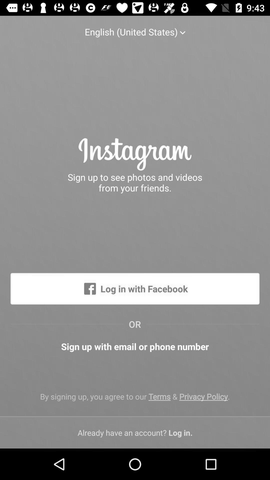

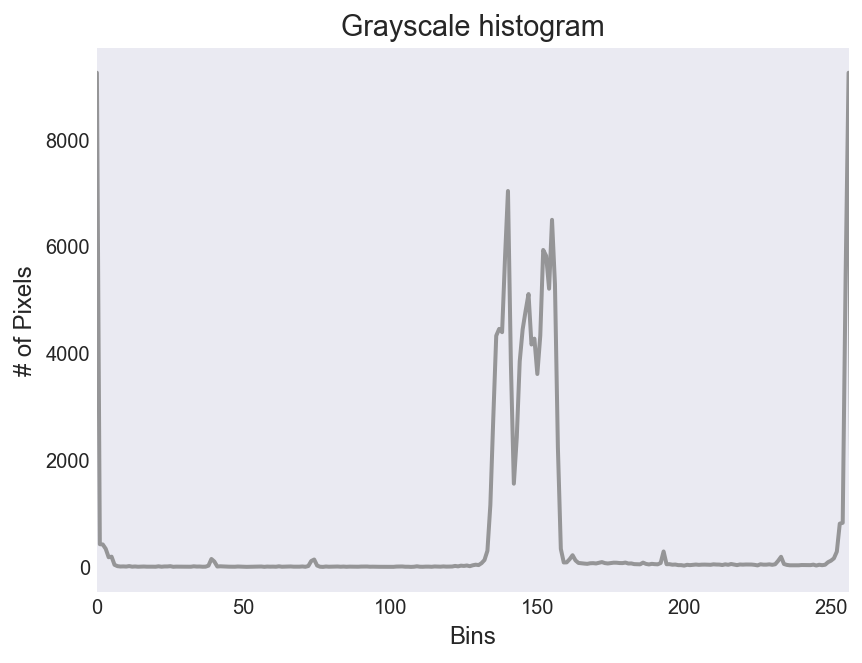

In [166]:
ui_histogram(app_ui_exp.filename_exp[27551])

App UI


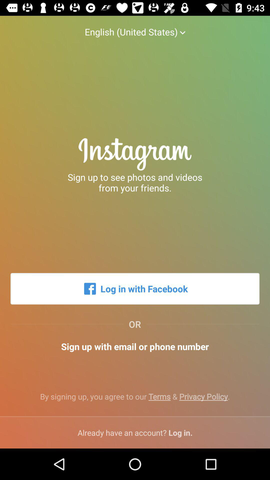

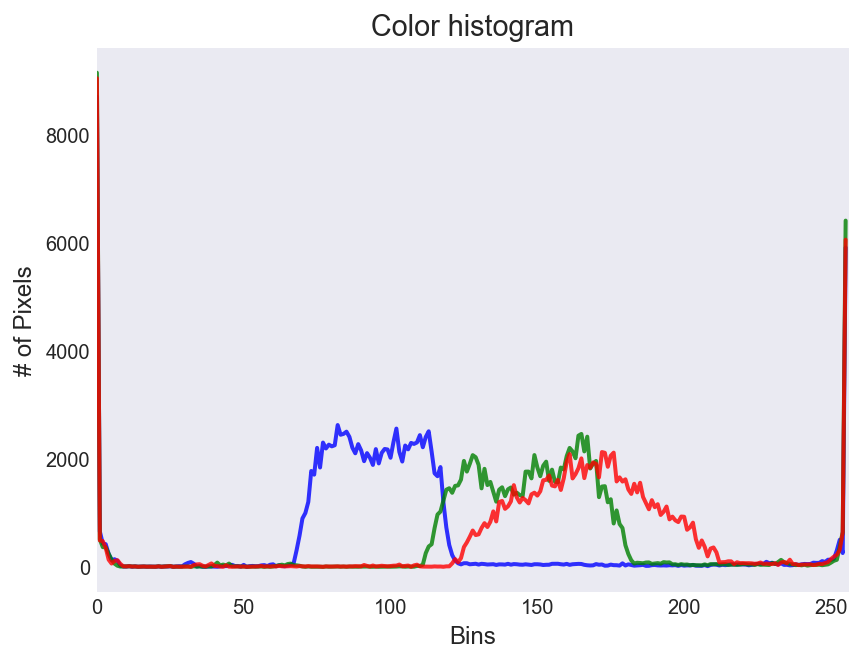

In [167]:
ui_histogram(app_ui_exp.filename_exp[27551], color="color")

App UI


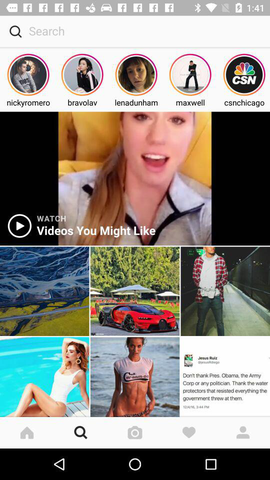

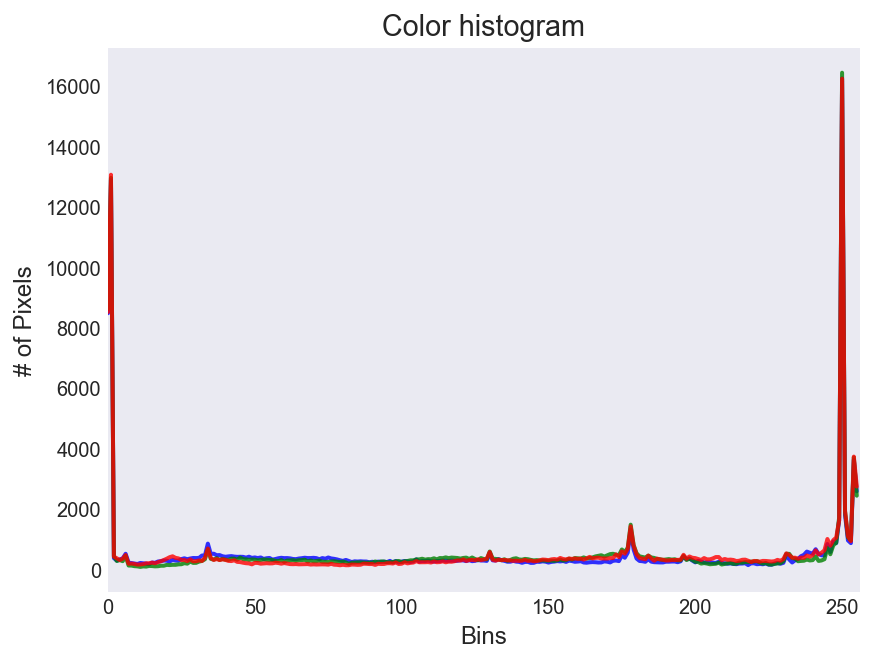

In [168]:
ui_histogram(app_ui_exp.filename_exp[27565], color="color")

## Entropy 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html



In [181]:
ig1 = pil_img(app_ui_exp.filename_exp[27551]).convert('LA').histogram()
ig2 = pil_img(app_ui_exp.filename_exp[27551]).histogram()
ig3 = pil_img(app_ui_exp.filename_exp[27565]).histogram()

In [191]:
def ui_entropy(vector):
    probilities = [(float(i) / sum(vector)) for i in vector]
    return - sum([p * np.log2(p) for p in probilities if p != 0])

In [194]:
ui_entropy(ig1)

6.2015605211806699

In [185]:
ui_entropy(ig2)

7.900660308491821

In [186]:
ui_entropy(ig3)

8.351097175505116

In [193]:
entropy(ig0, base=2)

6.2015605211806735

In [154]:
ig1 = PIL.Image.open(app_ui_exp.filename_exp[27551]).resize((270, 480), PIL.Image.ANTIALIAS).histogram()

In [155]:
entropy(ig1)

5.4763204173929818

In [157]:
ig2 = PIL.Image.open(app_ui_exp.filename_exp[27565]).resize((270, 480), PIL.Image.ANTIALIAS).histogram()

In [158]:
entropy(ig2)

5.7885394617834915